In [3]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

# New function definitions

In [4]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq, plot_psd, **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

# Directory structure

In [5]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220525',
 '/data/brownian/20220523']

In [6]:
# Select a date
date_der_index = 3
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220525/bead1']

In [7]:
# Select a bead
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220525/bead1/baseline',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow',
 '/data/brownian/20220525/bead1/40kHz-piezo_40kHz-10V-1burst']

In [8]:
# Select an experiment
experiment_der_index = 1
exp_fnames = find_files(experiment_ders[experiment_der_index])
exp_fnames

['/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_8.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_14.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_26.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_23.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_9.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_19.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_5.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_13.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_21.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_16.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_7.tdms',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow/iter_17.tdms',
 '/data/

# PSD calibration

In [9]:
baseline_experiment_index = (0,)
baseline_fnames = find_files(experiment_ders[baseline_experiment_index[0]])
for experiment_der_index in baseline_experiment_index[1:]:
    baseline_fnames.append(find_files(experiment_ders[experiment_der_index]))

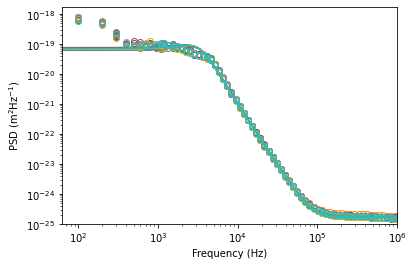

In [10]:
fmin = 5e2
fmax = 4e4
cutoff = 1000e3
taumax = 10e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(sort_fnames(baseline_fnames)):
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff, 
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg])    
krhoCalTs = np.array(krhoCalTs)

k : 11.502829132966815 0.3495065272910245 3.038439702536724
rho : 1479.7891798078276 23.814671071078255 1.6093286392437969
A : 0.6184883146297472 0.0174059576301962 2.8142742907949896
T : 21.797087372542386 0.007980871464524421 0.036614394061556414


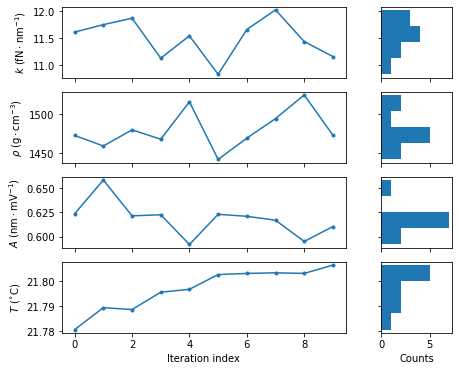

In [477]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "A", "T"]):
    vals = krhoCalTs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="A":
        vals = vals * 1e9/1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))

kbar,rhobar, calbar, Tbar = np.mean(krhoCalTs, axis=0)
response = VelocityResponse(R=C0.R, rho=rhobar, T=Tbar, c0=342.64, k=kbar)


In [478]:
response.c0

342.64

# 40 kHz Piezo drive

In [258]:
cutoff = 3e5
taumax = 20e-3
Deltaf = 500

## No bead

In [259]:
exp_fnames_NB = find_files('/data/brownian/20220523/no-bead/CW-40kHz-piezo_scan-amp_freq-narrow')
amps_NB = []
foss_NB = []
fnames_NB = []
for fname in sort_fnames(exp_fnames_NB):
    C = Collection(fname)
    fos = C.fos
    foss_NB.append(fos)
    amps_NB.append(C.amp)
    fnames_NB.append(fname)
foss_NB = np.unique(foss_NB)
amps_NB = np.unique(amps_NB)

In [260]:
# Convert to pressure data and compute PSD

fnamei = 0
Cs_NB = np.zeros((len(foss), len(amps)), dtype="object")
for fosi, fos in enumerate(foss_NB):
    for ampi, amp in enumerate(amps_NB):
        C = Collection(fnames_NB[fnamei])
        fnamei += 1
        
        C.set_collection("X")
        C.apply("calibrate", cal=C0.cal, inplace=True)
        C.apply("detrend", inplace=True, mode="constant")
        C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
        C.apply("differentiate", inplace=True)
        C.apply_func(response.correct_signal, tmin=C.t[0], tmax=C.t[-1],
                  correction="bassetbound", window="boxcar", impedance="plane", r0=5e-2)
        C.average("PSD", taumax=taumax)
        Cs_NB[fosi, ampi] = C

In [261]:
# Same analysis on baseline data
# NOTE Need C0 NB
#C0.set_collection("X")
#Npts = C0.r // (2*cutoff)
#C0.apply("calibrate", cal=C0.cal, inplace=True)
#C0.apply("detrend", inplace=True, mode="constant")
#C0.apply("bin_average", Npts=Npts, inplace=True)
#C0.apply("differentiate", inplace=True)
#C0.apply_func(response.correct_signal, tmin=C0.t[0], tmax=C0.t[-1],
#              correction="bassetbound", window="boxcar", impedance=None, r0=5e-2)
#C0.average("PSD", taumax=taumax)

30000.0 1.0 1.2913283555171189
30000.0 5.0 12.81501735120557
30000.0 9.0 48.352439673591405
35308.49980526828 1.0 12.165107562283223
35308.49980526828 5.0 336.8132634191363
35308.49980526828 9.0 670.7987108122828
41556.33861662098 1.0 3480.3342429491436
41556.33861662098 5.0 30754.732170850006
41556.33861662098 9.0 95807.88977155476
48909.73246508748 1.0 2.3552975833455636
48909.73246508748 5.0 36.07397244737788
48909.73246508748 9.0 183.07904738465837
57564.30930730882 1.0 2.607817930466038
57564.30930730882 5.0 56.81536748477691
57564.30930730882 9.0 59.12038515516096
67750.31346558387 1.0 4.036170032171112
67750.31346558387 5.0 55.4998046480425
67750.31346558387 9.0 154.5527893390805
79738.73099354775 1.0 2.605615419424778
79738.73099354775 5.0 29.709582318394133
79738.73099354775 9.0 61.48356377077999
93848.49892526734 1.0 1.544674428025312
93848.49892526734 5.0 12.652500629813808
93848.49892526734 9.0 31.36976726485277
110454.99020091735 1.0 1.1361379849860092
110454.99020091735 5

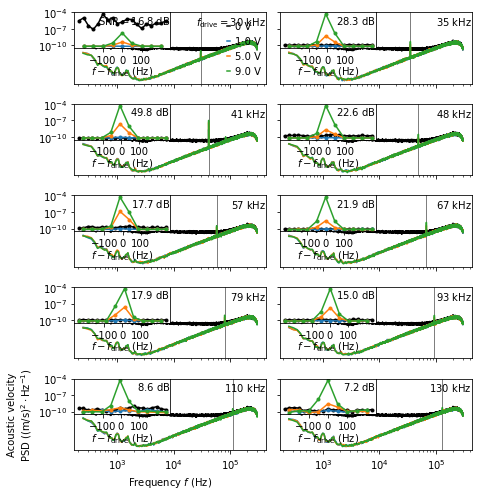

In [262]:
Nrow, Ncol = len(foss_NB)//2, 2
fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 7), sharex=True, sharey=True)

SNRs_NB = np.zeros((len(foss_NB), len(amps_NB)))
for fosi, fos in enumerate(foss_NB):
    fos *= 1e3
    r = fosi // Ncol
    c = fosi % Ncol
    ax = axs[r, c]
    inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
    #C0 -> C0_NB
    mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
    inmask0 = np.logical_and(C0.freq>fos-Deltaf/2, C0.freq<min(fos+Deltaf/2, 2.0e6))
    ax.loglog(C0.freq[mask0], C0.psd[mask0], c="k", label="0 V")
    inax.plot(C0.freq[inmask0]-fos, C0.psd[inmask0]*1e6, marker=".", c="k")
    ax.axvline(fos, lw=0.5, c="k")
    for ampi, amp in enumerate(amps_NB):
        color = f"C{ampi}"
        C = Cs_NB[fosi, ampi]
        freq, psd = C.freq, C.psd
        inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

        mask = np.logical_and(freq<cutoff, freq>230)
        ax.loglog(freq[mask], psd[mask], label="%s V"%amp, c=color)
        #ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
        inax.plot(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
        max_dex = np.argmax(psd[inmask])
        mx = psd[inmask][max_dex]
        mn = psd[inmask][max_dex-5]
        SNR = mx/mn
        SNRs_NB[fosi, ampi] = SNR
        print(fos, amp, SNR)
        if c==0 and r==0:
            drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
        else:
            drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
        if ampi == len(amps)-1:
            ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
            inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
        inax.set_yticks([])
        inax.set_xticks([-100, 0, 100])
        inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
#axs[-1,0].set_yscale("log")
axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
plt.tight_layout()
#plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
dB_SNRs_NB = 10*np.log10(SNRs_NB)

## With Bead (and microphone)

In [263]:
# Sort file names by scan parameters

experiment_der_index = 1
exp_fnames = find_files(experiment_ders[experiment_der_index])

amps = []
foss = []
fnames = []
for fname in sort_fnames(exp_fnames):
    C = Collection(fname)
    fos = C.fos
    foss.append(fos)
    amps.append(C.amp)
    fnames.append(fname)
foss = np.unique(foss)
amps = np.unique(amps)

In [264]:
# Convert to pressure data and compute PSD

fnamei = 0
Cs = np.zeros((len(foss), len(amps)), dtype="object")
for fosi, fos in enumerate(foss):
    for ampi, amp in enumerate(amps):
        C = Collection(fnames[fnamei])
        fnamei += 1
        
        C.set_collection("X")
        C.apply("calibrate", cal=C0.cal, inplace=True)
        C.apply("detrend", inplace=True, mode="constant")
        C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
        C.apply("differentiate", inplace=True)
        C.apply_func(response.correct_signal, tmin=C.t[0], tmax=C.t[-1],
                  correction="bassetbound", window="boxcar", impedance="plane", r0=5e-2)
        C.average("PSD", taumax=taumax)
        Cs[fosi, ampi] = C

In [265]:
C0.set_collection("X")
Npts = C0.r // (2*cutoff)
C0.apply("calibrate", cal=C0.cal, inplace=True)
C0.apply("detrend", inplace=True, mode="constant")
C0.apply("bin_average", Npts=Npts, inplace=True)
C0.apply("differentiate", inplace=True)
C0.apply_func(response.correct_signal, tmin=C0.t[0], tmax=C0.t[-1],
              correction="bassetbound", window="boxcar", impedance=None, r0=5e-2)
C0.average("PSD", taumax=taumax)

(array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 3.1240e+05, 3.1245e+05,
        3.1250e+05]),
 array([7.26611829e-11, 2.66358942e-10, 3.87870020e-10, ...,
        2.36633651e-15, 5.91253796e-15, 1.05897584e-14]))

20000.0 1.0 1.185799270770709
20000.0 5.0 1.3107409167429513
20000.0 9.0 1.7089395744129512
24623.72214713907 1.0 1.0161411407410144
24623.72214713907 5.0 4.024399748842367
24623.72214713907 9.0 18.07183070099135
30316.384618975357 1.0 1.3833442134226521
30316.384618975357 5.0 6.726953298805262
30316.384618975357 9.0 23.93364799144118
37325.111568172484 1.0 304.72755376332515
37325.111568172484 5.0 9454.522356750294
37325.111568172484 9.0 30044.91652725583
45954.15881828227 1.0 126.33705815863766
45954.15881828227 5.0 3986.2720342992666
45954.15881828227 9.0 11242.153865535125
56578.12191234416 1.0 27.864162259271303
56578.12191234416 5.0 744.6727848512965
56578.12191234416 9.0 2456.4625173315476
69658.19767882615 1.0 31.7030267925348
69658.19767882615 5.0 856.3288306202669
69658.19767882615 9.0 2733.5071052969874
85762.20524569515 1.0 1.5125473380823475
85762.20524569515 5.0 9.606963759173802
85762.20524569515 9.0 31.112332446496236
105589.2356347955 1.0 4.643455773829616
105589.23563

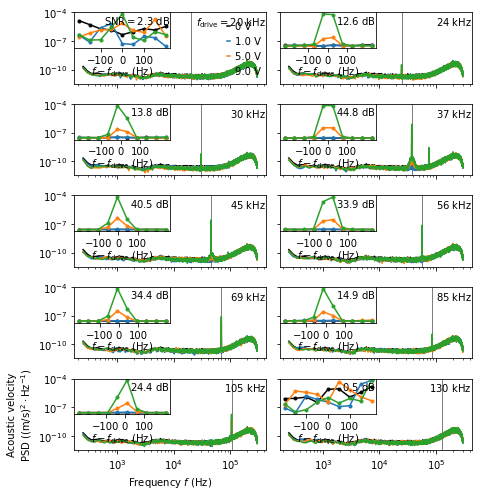

In [266]:
Nrow, Ncol = len(foss)//2, 2
fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 7), sharex=True, sharey=True)

SNRs = np.zeros((len(foss), len(amps)))
for fosi, fos in enumerate(foss):
    fos *= 1e3
    r = fosi // Ncol
    c = fosi % Ncol
    ax = axs[r, c]
    inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
    mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
    inmask0 = np.logical_and(C0.freq>fos-Deltaf/2, C0.freq<min(fos+Deltaf/2, 2.0e6))
    ax.loglog(C0.freq[mask0], C0.psd[mask0], c="k", label="0 V")
    inax.plot(C0.freq[inmask0]-fos, C0.psd[inmask0]*1e6, marker=".", c="k")
    ax.axvline(fos, lw=0.5, c="k")
    for ampi, amp in enumerate(amps):
        color = f"C{ampi}"
        C = Cs[fosi, ampi]
        freq, psd = C.freq, C.psd
        inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

        mask = np.logical_and(freq<cutoff, freq>230)
        ax.loglog(freq[mask], psd[mask], label="%s V"%amp, c=color)
        #ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
        inax.plot(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
        max_dex = np.argmax(psd[inmask])
        mx = psd[inmask][max_dex]
        mn = C0.psd[inmask0][max_dex]
        SNR = mx/mn
        SNRs[fosi, ampi] = SNR
        print(fos, amp, SNR)
        if c==0 and r==0:
            drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
        else:
            drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
        if ampi == len(amps)-1:
            ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
            inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
        inax.set_yticks([])
        inax.set_xticks([-100, 0, 100])
        inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
#axs[-1,0].set_yscale("log")
axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
plt.tight_layout()
#plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
dB_SNRs = 10*np.log10(SNRs)

In [267]:
# Convert to pressure data and compute PSD

fnamei = 0
Cs_mic = np.zeros((len(foss), len(amps)), dtype="object")
for fosi, fos in enumerate(foss):
    for ampi, amp in enumerate(amps):
        C = Collection(fnames[fnamei])
        fnamei += 1
        
        C.set_collection("Y")
        #C.apply("calibrate", cal=C0.cal, inplace=True)
        C.apply("detrend", inplace=True, mode="constant")
        C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
        C.average("PSD", taumax=taumax)
        Cs_mic[fosi, ampi] = C

In [268]:
C0_mic = Collection(baseline_fnames[-1])
C0_mic.set_collection("Y")
Npts = C0_mic.r // (2*cutoff)
#C0_mic.apply("calibrate", cal=C0_mic.cal, inplace=True)
C0_mic.apply("detrend", inplace=True, mode="constant")
C0_mic.apply("bin_average", Npts=Npts, inplace=True)
C0_mic.average("PSD", taumax=taumax);

20000.0 1.0 30803.687794483056
20000.0 5.0 810555.5883430998
20000.0 9.0 2663980.085837058
24623.72214713907 1.0 10994.229336245406
24623.72214713907 5.0 277430.3085561161
24623.72214713907 9.0 939639.5177529458
30316.384618975357 1.0 115.7070815703981
30316.384618975357 5.0 2877.496996834061
30316.384618975357 9.0 8412.68482921623
37325.111568172484 1.0 420595.8673202301
37325.111568172484 5.0 10561730.108632213
37325.111568172484 9.0 35241172.14222054
45954.15881828227 1.0 716445.2036417173
45954.15881828227 5.0 18366407.030106016
45954.15881828227 9.0 58670325.53830789
56578.12191234416 1.0 606100.8960711476
56578.12191234416 5.0 15402232.560953079
56578.12191234416 9.0 51487996.87039246
69658.19767882615 1.0 1351413.757333092
69658.19767882615 5.0 34419796.322741516
69658.19767882615 9.0 114342644.09271583
85762.20524569515 1.0 1714.286062009285
85762.20524569515 5.0 42772.72935866369
85762.20524569515 9.0 139483.02857146357
105589.2356347955 1.0 3198.8830311114725
105589.235634795

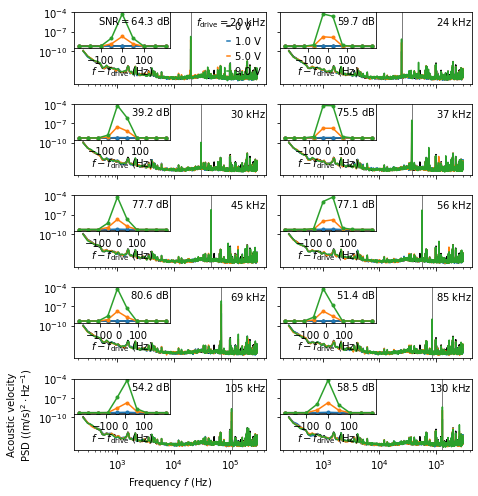

In [269]:
Nrow, Ncol = len(foss)//2, 2
fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 7), sharex=True, sharey=True)

SNRs_mic = np.zeros((len(foss), len(amps)))
for fosi, fos in enumerate(foss):
    fos *= 1e3
    r = fosi // Ncol
    c = fosi % Ncol
    ax = axs[r, c]
    inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
    mask0 = np.logical_and(C0_mic.freq<cutoff, C0_mic.freq>230)
    inmask0 = np.logical_and(C0_mic.freq>fos-Deltaf/2, C0_mic.freq<min(fos+Deltaf/2, 2.0e6))
    ax.loglog(C0_mic.freq[mask0], C0_mic.psd[mask0], c="k", label="0 V")
    inax.plot(C0_mic.freq[inmask0]-fos, C0_mic.psd[inmask0]*1e6, marker=".", c="k")
    ax.axvline(fos, lw=0.5, c="k")
    for ampi, amp in enumerate(amps):
        color = f"C{ampi}"
        C = Cs_mic[fosi, ampi]
        freq, psd = C.freq, C.psd
        inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

        mask = np.logical_and(freq<cutoff, freq>230)
        ax.loglog(freq[mask], psd[mask], label="%s V"%amp, c=color)
        #ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
        inax.plot(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
        max_dex = np.argmax(psd[inmask])
        mx = psd[inmask][max_dex]
        mn = C0_mic.psd[inmask0][max_dex]
        SNR = mx/mn
        SNRs_mic[fosi, ampi] = SNR
        print(fos, amp, SNR)
        if c==0 and r==0:
            drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
        else:
            drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
        if ampi == len(amps)-1:
            ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
            inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
        inax.set_yticks([])
        inax.set_xticks([-100, 0, 100])
        inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
#axs[-1,0].set_yscale("log")
axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
plt.tight_layout()
#plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
dB_SNRs_mic = 10*np.log10(SNRs_mic)

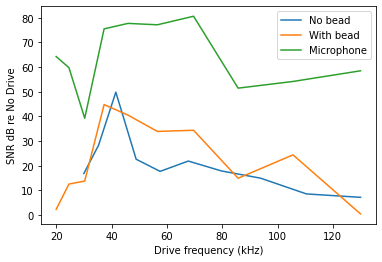

In [270]:
plt.plot(foss_NB, dB_SNRs_NB[:, -1], label="No bead")
plt.plot(foss,  [:,-1], label="With bead")
plt.plot(foss, dB_SNRs_mic[:,-1], label="Microphone")
plt.xlabel("Drive frequency (kHz)")
plt.ylabel("SNR dB re No Drive")
plt.legend()


 # Resonant single burst

In [273]:
experiment_ders

['/data/brownian/20220525/bead1/baseline',
 '/data/brownian/20220525/bead1/CW-40kHz-piezo_scan-amp_freq-narrow',
 '/data/brownian/20220525/bead1/40kHz-piezo_40kHz-10V-1burst']

In [354]:
fname = find_files(experiment_ders[2])[0]

In [453]:
cutoff = 250e3
C = Collection(fname)
C.set_collection("X")
C.apply("calibrate", cal=C0.cal, inplace=True)
C.apply("detrend", inplace=True, mode="constant")
C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
C.apply("differentiate", inplace=True)
C.apply_func(response.correct_signal, tmin=C.t[0], tmax=C.t[-1],
             correction="bassetbound", window="boxcar", impedance="plane", r0=5e-2)
C.apply("lowpass", cutoff=cutoff/2, inplace=True)
C.average("PSD", taumax=taumax)
C.aggrigate();

In [454]:
C_mic = Collection(fname)
C_mic.set_collection("Y")
C_mic.apply("calibrate", cal=1, inplace=True)
C_mic.apply("detrend", inplace=True, mode="constant")
C_mic.apply("bin_average", Npts=C_mic.r // (2*cutoff), inplace=True)
C_mic.average("PSD", taumax=taumax)
C_mic.aggrigate();

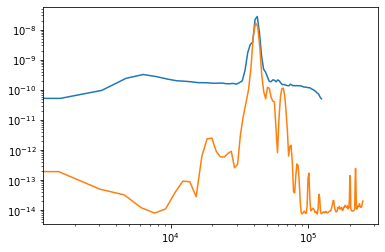

In [460]:
plt.loglog(C.freq[C.freq<cutoff/2], C.psd[C.freq<cutoff/2])
plt.loglog(C_mic.freq[C_mic.freq<cutoff], C_mic.psd[C_mic.freq<cutoff])
#plt.loglog(C0.freq[C0.freq<cutoff], C0.psd[C0.freq<cutoff])

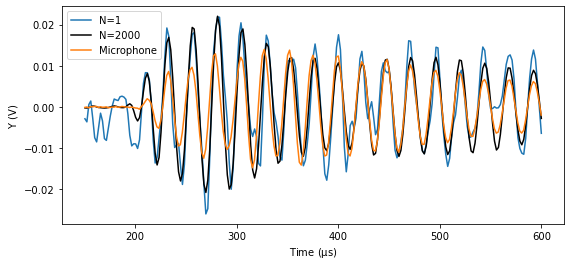

In [456]:
tmin = 150e-6
tmax=600e-6
fig, ax = C.collection[0].plot(unit="Pa", tunit="us", tmin=tmin, tmax=tmax, label="N=1")
C.agg.plot(unit="Pa", tunit="us", tmin=tmin, tmax=tmax, ax=ax, label="N=2000", c="k")
C_mic.collection[0].plot(unit="V", tunit="us", shift=-4e-6, tmin=tmin, tmax=tmax, ax=ax, label="Microphone")
plt.legend()

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time ($\\rm \\mu s$)', ylabel='X_aggrigate ($\\rm Pa$)'>)

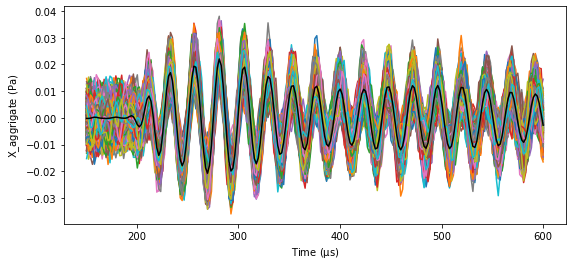

In [457]:
tmin = 150e-6
tmax=600e-6
fig, ax = C.collection[0].plot(unit="Pa", tunit="us", tmin=tmin, tmax=tmax)
for D in C.collection[1:]:
    D.plot(unit="Pa", tunit="us", tmin=tmin, tmax=tmax, ax=ax)
C.agg.plot(unit="Pa", tunit="us", tmin=tmin, tmax=tmax, ax=ax, c="k")

In [29]:
response0 = VelocityResponse(R=1e-6, rho=C0.rho, T=C0.Tavg, c0=344, k=C0.k)
response1 = VelocityResponse(R=C0.R, rho=C0.rho, T=C0.Tavg, c0=344, k=C0.k)
response2 = VelocityResponse(R=2e-6, rho=C0.rho, T=C0.Tavg, c0=344, k=C0.k)

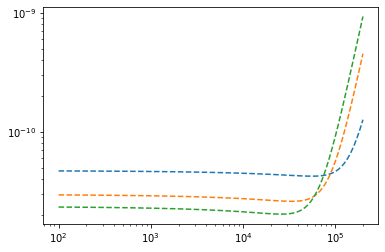

In [32]:
fs = np.geomspace(1e2,2e5,100)
plt.loglog(fs, response0.Sv_basset(fs, chi=C0.xnoise2)/response0.amplitude("bassetbound", fs)**2, ls="--")
plt.loglog(fs, response1.Sv_basset(fs, chi=C0.xnoise2)/response1.amplitude("bassetbound", fs)**2, ls="--")
plt.loglog(fs, response2.Sv_basset(fs, chi=C0.xnoise2)/response2.amplitude("bassetbound", fs)**2, ls="--")